# `ALTO` XML Layout Exploration
This notebook visualizes the page segmentation layout annotations that are output from [`pdfalto`](https://github.com/kermitt2/pdfalto) in [ALTO AML format](https://github.com/altoxml/documentation/wiki). 

It does so by loading the XML generated for the PDF, loading the PDF and creating an image object with `pillow`, then doing some basic math with the location attributes available for `TextBlock` elements.

In [1]:
from collections import Counter
from contextlib import closing
from operator import mul
from pathlib import Path
import json
import xml.etree.ElementTree as ET

import pypdfium2 as pdfium
from IPython.display import display
from PIL import ImageFont, ImageDraw
import xmltodict
from rich import print, print_json


In [2]:
PMC_ARTICLE_ID = "PMC2911601"

pdf = pdfium.PdfDocument(f"data/selected/{PMC_ARTICLE_ID}.pdf")

In [3]:
alto_dict = xmltodict.parse(Path(f"data/selected/alto/{PMC_ARTICLE_ID}.xml").read_text())
alto_xml = ET.fromstring(Path(f"data/selected/alto/{PMC_ARTICLE_ID}.xml").read_text())

In [4]:
pages = alto_xml.findall(".//{http://www.loc.gov/standards/alto/ns-v3#}Page")

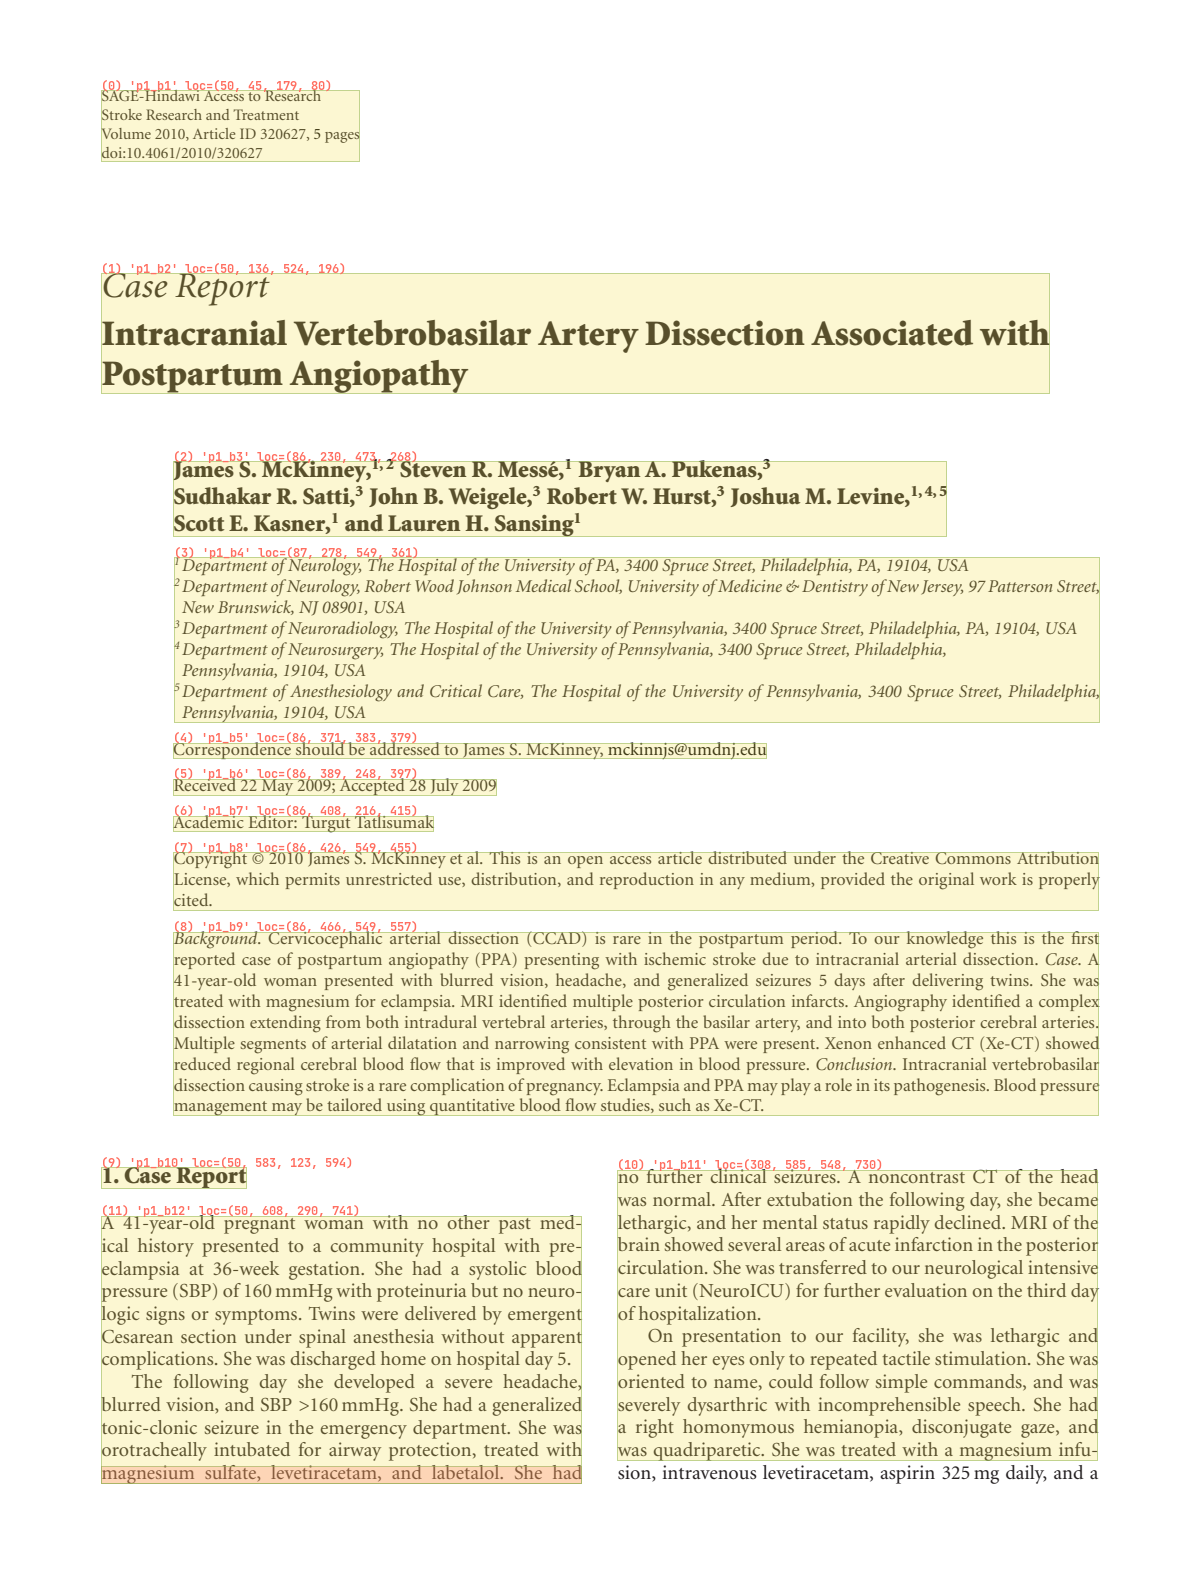

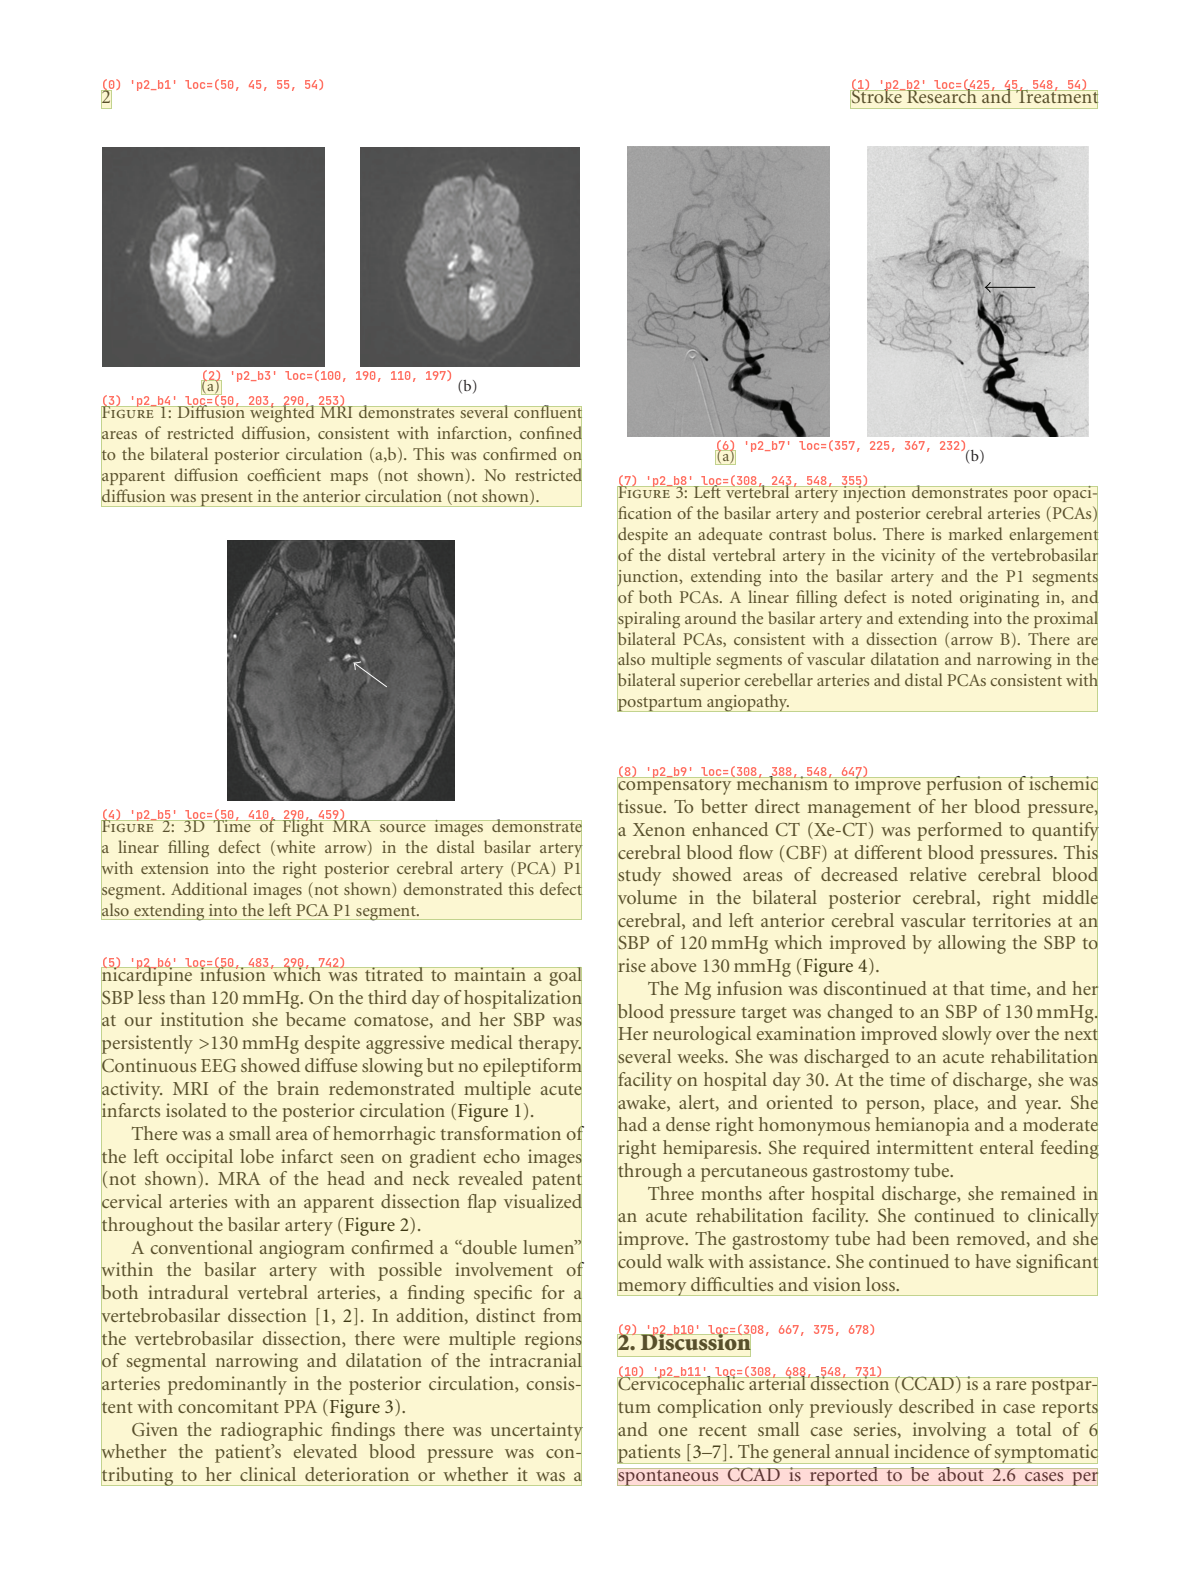

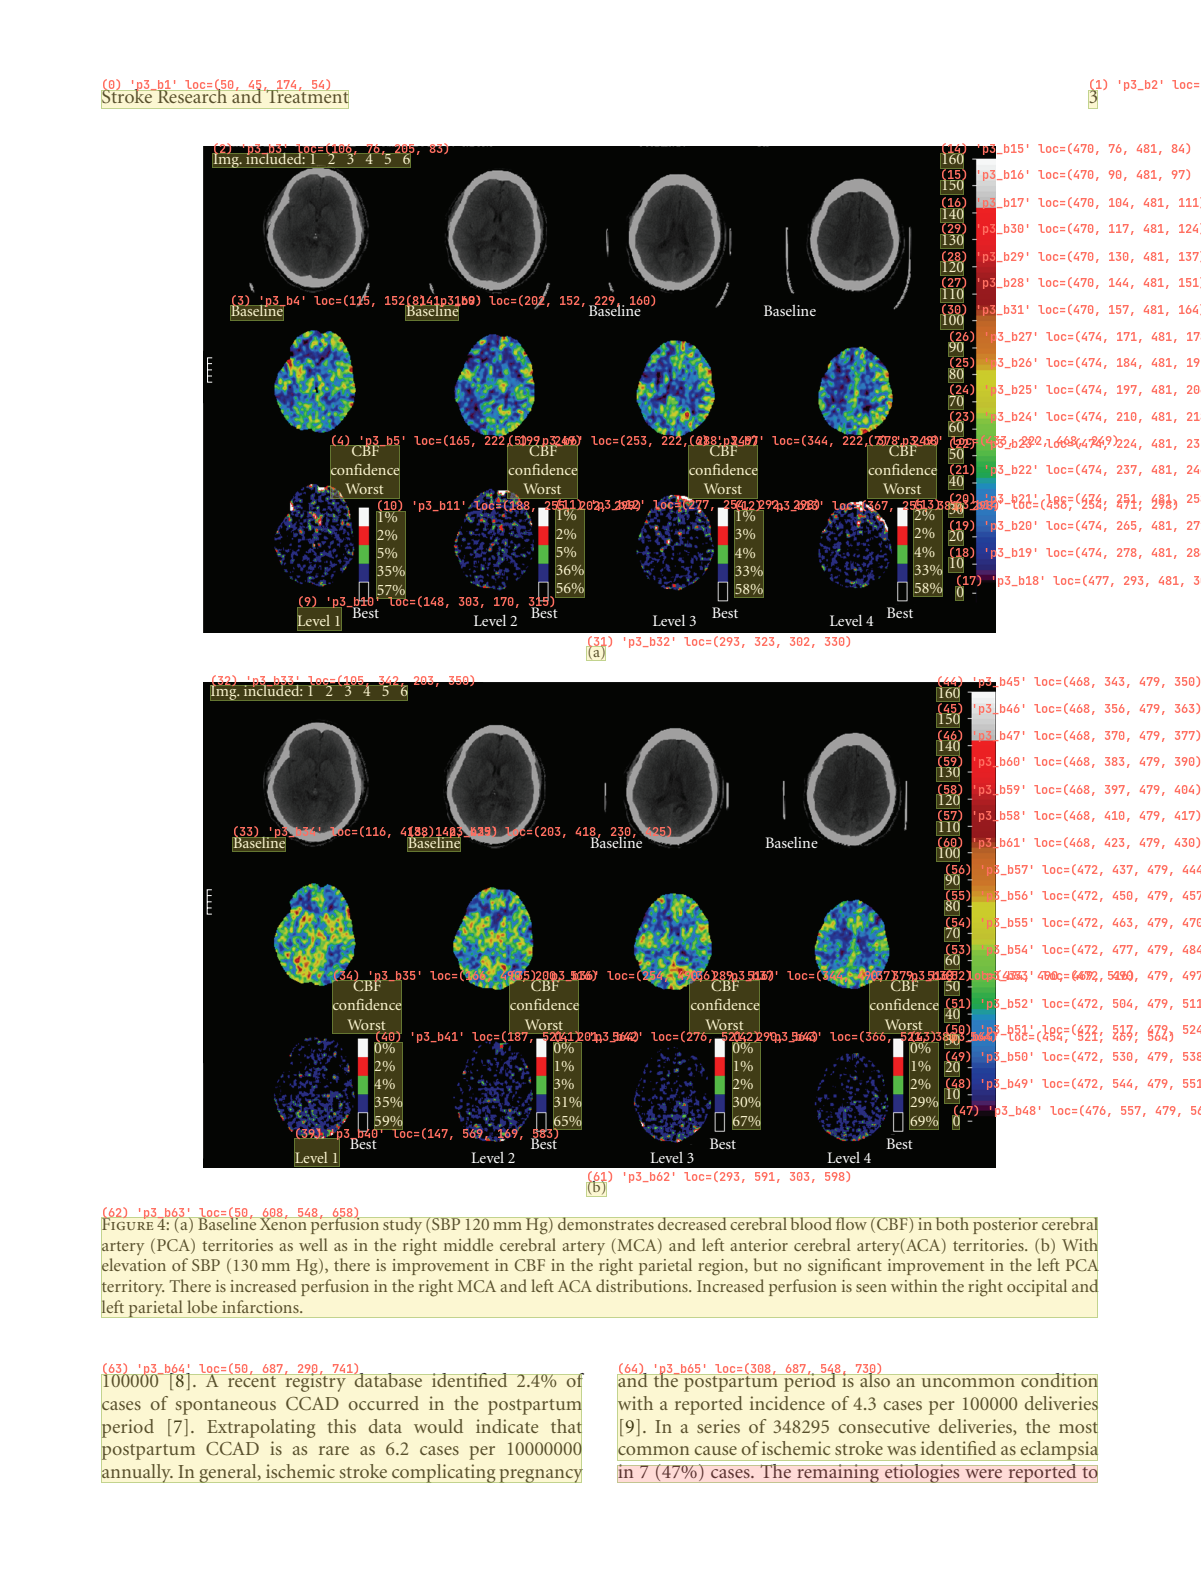

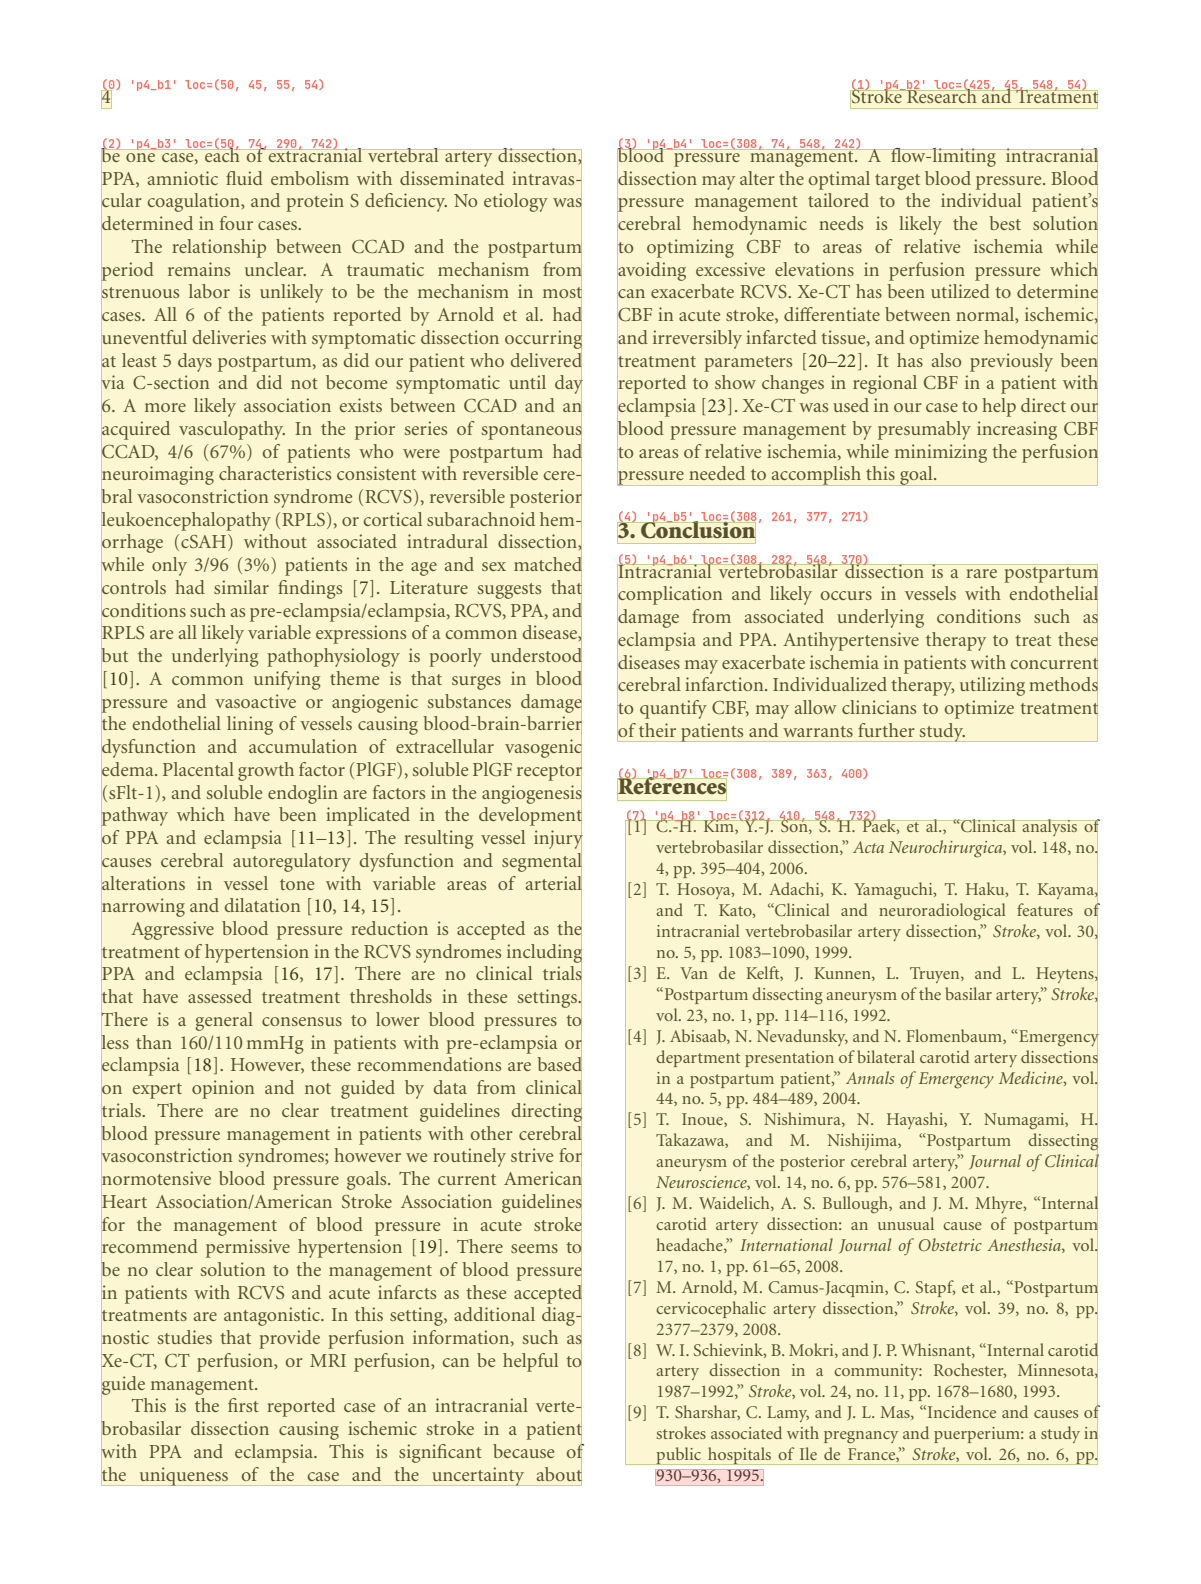

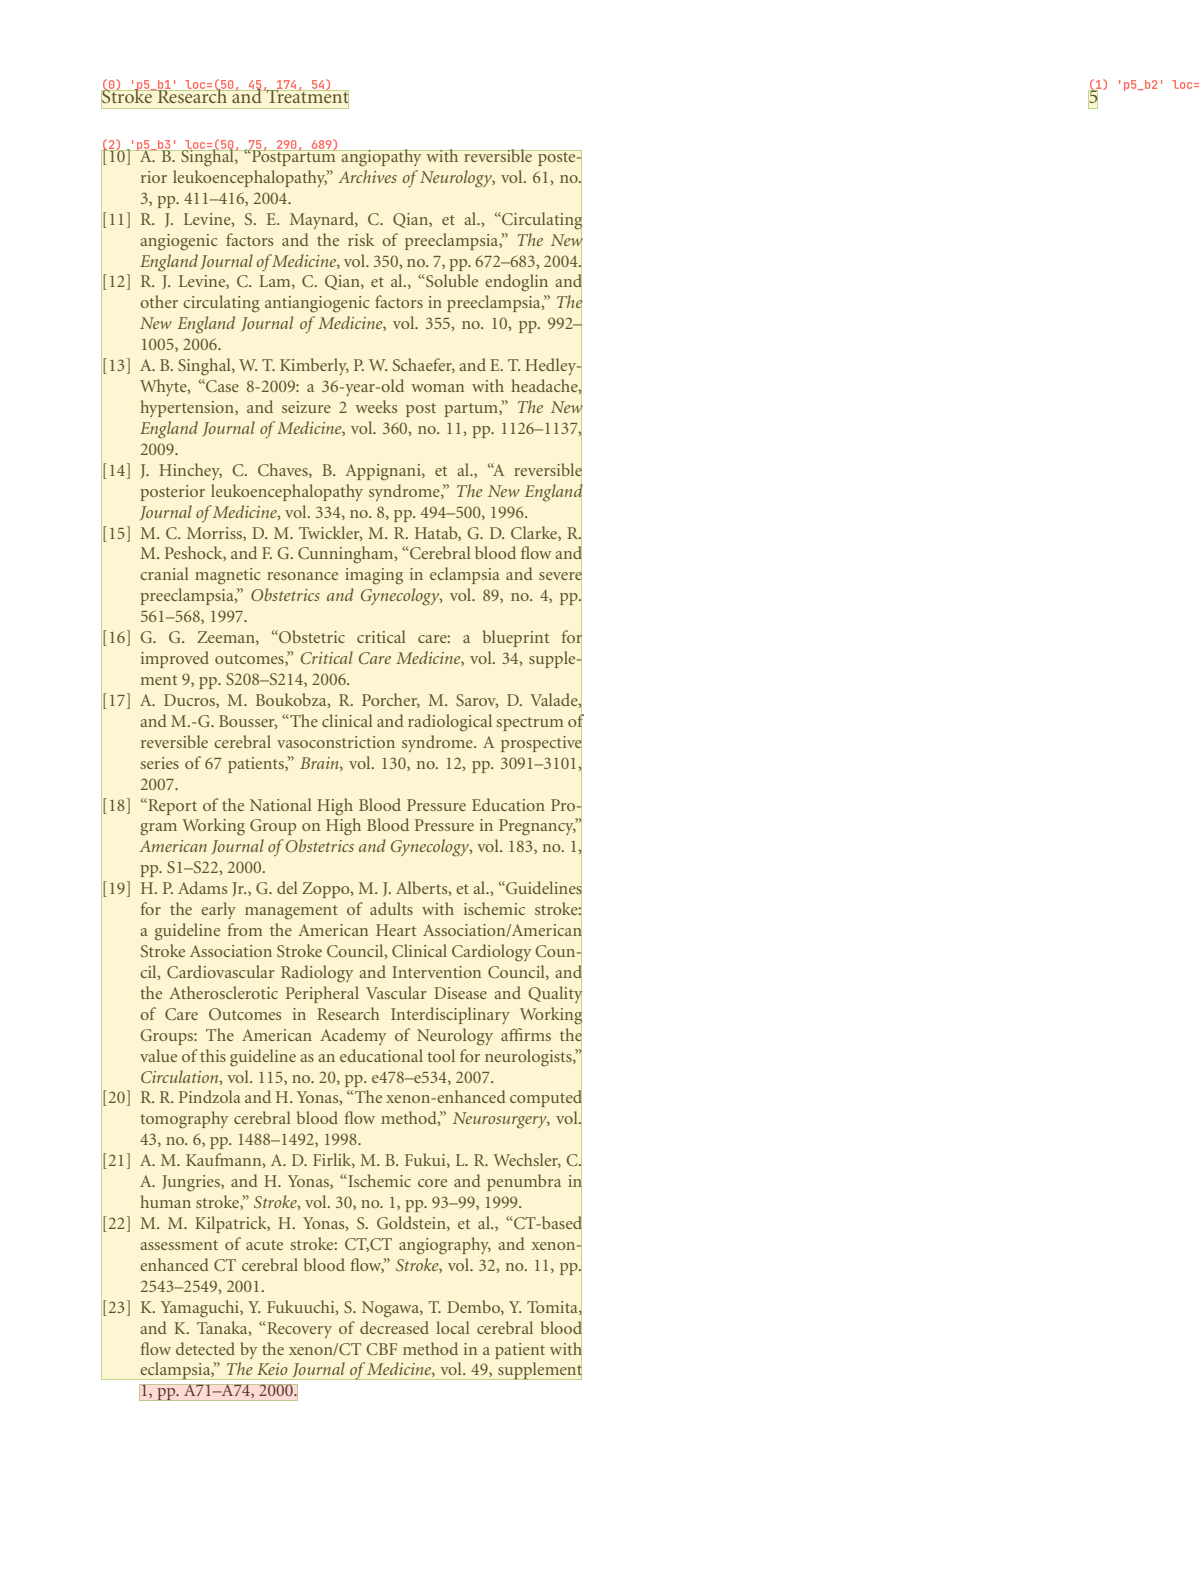

In [5]:
bbox_color = (245, 223, 77, 64)
bbox_outline_color = (136, 176, 75, 128)
line_annotation_color = (255, 111, 97, 64)
text_color = (255, 111, 97, 255)

pages = list(alto_xml.findall(".//{http://www.loc.gov/standards/alto/ns-v3#}Page"))

for pnumber in range(len(pdf)):
    xml_page = pages[pnumber]
    textblocks = list(xml_page.findall(".//{http://www.loc.gov/standards/alto/ns-v3#}TextBlock"))
    with closing(pdf.get_page(pnumber)) as page:
        scale = 144 / 72  # 300 dpi
        page_height = h = page.get_height() * scale
        image = page.render_topil(scale=scale)
        draw = ImageDraw.Draw(image, mode="RGBA")
        font = ImageFont.truetype("JetBrainsMono-Bold.ttf", int(6 * scale))

        for i, block_el in enumerate(textblocks):
            block = block_el.attrib
            id = block["ID"]
            x1, y1 = float(block['HPOS']), float(block['VPOS'])
            x2, y2 = x1 + float(block['WIDTH']), y1 + (float(block["HEIGHT"]))
            # apply the scaling
            x1, y1, x2, y2 = map(mul, (x1, y1, x2, y2), [scale] * 4)
            loc = tuple(map(int, (x1/scale, y1/scale, x2/scale, y2/scale)))
            (tx1, ty1, tx2, ty2) = draw.textbbox((x1, y1), text=str(i), font=font)
            t_h = ty1 - ty2
            draw.rectangle((x1, y1, x2, y2), fill=bbox_color, outline=bbox_outline_color)
            draw.text((x1, y1+(t_h*1.5)), text=f"({i}) '{id}' loc={loc}", font=font, fill=text_color)
            # There is a bug where one of the final boxes doesn't get the last line
            # added to it. This is an attempt to visualize the last line of the last 
            # TextBlock. This isn't always the right one, but I can't quite figure out 
            # what the property of the TextBlock that doesn't get fully merged is.
            if i == len(textblocks) - 1:
                last_line_el = block_el.findall(".//{http://www.loc.gov/standards/alto/ns-v3#}TextLine")[-1]
                last_line = last_line_el.attrib
                x1, y1 = float(last_line['HPOS']), float(last_line['VPOS'])
                x2, y2 = x1 + float(last_line['WIDTH']), y1 + (float(last_line["HEIGHT"]))
                x1, y1, x2, y2 = map(mul, (x1, y1, x2, y2), [scale] * 4)
                draw.rectangle((x1, y1, x2, y2), fill=line_annotation_color, outline=bbox_outline_color)


    display(image)
    
    image.save(f"output/{PMC_ARTICLE_ID}_{pnumber}_alto_textblock.png")

## Other Stuff
Here's a printout of the other two top-level keys that _aren't_ `Layout`.

In [6]:
top_level_keys = ["Description", "Styles"]

for key in top_level_keys:
    print(f"Key: {key}")
    print_json(data=(alto_dict['alto'][key]))

Key: Description

{
  "MeasurementUnit": "pixel",
  "sourceImageInformation": {
    "fileName": "/home/jovyan/input/pdf/PMC2911601.pdf"
  },
  "OCRProcessing": {
    "@ID": "IdOcr",
    "ocrProcessingStep": {
      "processingDateTime": "2023-01-02T14:55:32Z",
      "processingSoftware": {
        "softwareCreator": "CONTRIBUTORS",
        "softwareName": "pdfalto",
        "softwareVersion": "0.4"
      }
    }
  }
}

Key: Styles

{
  "TextStyle": [
    {
      "@ID": "font0",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "7.970",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f"
    },
    {
      "@ID": "font1",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "7.970",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "000000"
    },
    {
      "@ID": "font2",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "17.933",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f",
      "@FONTSTYLE": "italics"
    },
    {
      "@ID": "font3",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "17.933",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f",
      "@FONTSTYLE": "bold"
    },
    {
      "@ID": "font4",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "11.955",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f",
      "@FONTSTYLE": "bold"
    },
    {
      "@ID": "font5",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "7.970",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f",
      "@FONTSTYLE": "bold superscript"
    },
    {
      "@ID": "font6",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "5.978",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f",
      "@FONTSTYLE": "italics superscript"
    },
    {
      "@ID": "font7",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "8.966",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f",
      "@FONTSTYLE": "italics"
    },
    {
      "@ID": "font8",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "8.966",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f"
    },
    {
      "@ID": "font9",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "8.966",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "000000"
    },
    {
      "@ID": "font10",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "9.963",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f"
    },
    {
      "@ID": "font11",
      "@FONTFAMILY": "minionpromath",
      "@FONTSIZE": "9.963",
      "@FONTTYPE": "sans-serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "231f1f",
      "@FONTSTYLE": "italics"
    },
    {
      "@ID": "font12",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "9.963",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "000000"
    },
    {
      "@ID": "font13",
      "@FONTFAMILY": "minion",
      "@FONTSIZE": "8.000",
      "@FONTTYPE": "serif",
      "@FONTWIDTH": "proportional",
      "@FONTCOLOR": "ffffff"
    }
  ]
}